In [1]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [3]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Cod

In [4]:
M_order=3

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³"
ro3=1141  # Elastic sphere Density "kg/m³"
ro4=51.3  # Inner Gas Sphere Density "kg/m³"

c1=1479    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=325.1    # gas speed of sound "m/s"

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=0.17*1.0E6  # "N/m²" shear rigidity of elastic shell
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"
    
Delta=0.01*1E-3 # Swimbladder wall thickness
#R4=0.14*1E-3 #0.001  # (m) radius of gas sphere
#R3=R4+Delta  # (m) radius of elastic shell 
#R2=2*1E-3  # (m) radius till viscous layer
#R2=R4*( (1+(ro1-ro4)/(ro2-ro1))**(1/3) ) # Eq 18 in our JASA mesopelagic paper

In [5]:
c3

1450.4192630279922

In [6]:
# set fixed values
params_cod ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Variable Parameters
For these model simulations the only variable is the **SHAPE.**

The main variable parameter is R3- the radius of the swimbladder including the wall. In the case of Limacina it is the whole measured length (or calculated width).

The other two variable parameters are R4- radius of the swimbladder (R3-thickness of swimbladder wall) and R2-radius of fish fesh, since there is not flesh around the shell in a Limacina, we use R4=R3.

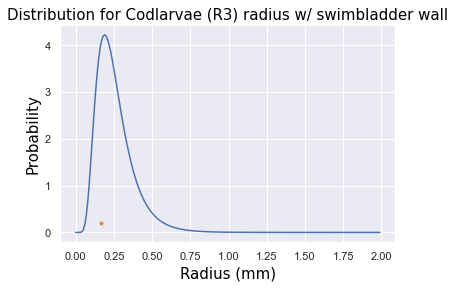

In [7]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# radius distribution was calculated using all measured lengths and their associated widths (L/a=1.5 Stanton 2000)
# For lognorm dist s = sigma, scale  = exp(mean)
x=np.arange(0,2,0.01)
R3_dist = stats.lognorm.pdf(x,s=0.45, scale = np.exp(-1.46))

plt.plot(x,R3_dist)
plt.plot(np.random.lognormal(mean=-1.46, sigma=0.45),0.2, '.')
plt.title('Distribution for Codlarvae (R3) radius w/ swimbladder wall', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

# Calculate the total length from the swimbladder size.
WHY? The swimbladder distribution is best...

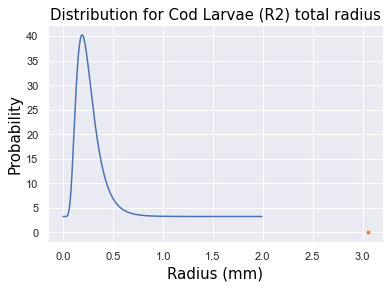

In [8]:
# Radius R2 distribution
# Values from lengthDist.Rmd.
# radius distribution was calculated using all measured lengths and their associated widths (L/a=1.5 Stanton 2000)
# For gamma scale is 1/rate. shape is alpha. 
# Using Lnorm for it to go to zero at zero.
#x=np.arange(0,20,0.01)
#R2_dist = stats.lognorm.pdf(x,s=1.29, scale = np.exp(0.23))
R2_dist = (8.77*R3_dist)+3.24
plt.plot(x,R2_dist)
plt.plot(np.random.lognormal(mean=np.exp(0.23),sigma=1.29),0.00, '.')
plt.title('Distribution for Cod Larvae (R2) total radius', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

In [9]:
print(R3_dist)

[0.00000000e+00 2.18819724e-09 1.58256034e-05 9.53282347e-04
 1.06714579e-02 5.24397594e-02 1.60447747e-01 3.63366707e-01
 6.70929518e-01 1.07116536e+00 1.53601620e+00 2.02998776e+00
 2.51788192e+00 2.96993507e+00 3.36427448e+00 3.68732693e+00
 3.93296161e+00 4.10102499e+00 4.19572339e+00 4.22412204e+00
 4.19488993e+00 4.11732896e+00 4.00067379e+00 3.85362384e+00
 3.68406056e+00 3.49890440e+00 3.30407151e+00 3.10449789e+00
 2.90420570e+00 2.70639326e+00 2.51353543e+00 2.32748553e+00
 2.14957291e+00 1.98069288e+00 1.82138717e+00 1.67191443e+00
 1.53231074e+00 1.40244083e+00 1.28204084e+00 1.17075351e+00
 1.06815679e+00 9.73786853e-01 8.87156244e-01 8.07768146e-01
 7.35127258e-01 6.68747981e-01 6.08160407e-01 5.52914528e-01
 5.02583040e-01 4.56763031e-01 4.15076818e-01 3.77172110e-01
 3.42721688e-01 3.11422713e-01 2.82995780e-01 2.57183794e-01
 2.33750739e-01 2.12480387e-01 1.93174987e-01 1.75653963e-01
 1.59752640e-01 1.45321020e-01 1.32222610e-01 1.20333316e-01
 1.09540399e-01 9.974150

## Set up simulation

In [10]:
# Frequency range
min_freq=283*1000
max_freq=383.1*1000
frequencySpacing=100
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run ensembles

In [11]:
nsim = 1000
nfreqs = len(Freq_vec)

# Allocate space for speed
R2_ensemble = np.zeros((nsim,1))
R3_ensemble = np.zeros((nsim,1))
TS_simulations = np.zeros((nsim*nfreqs))
freqs=np.zeros((nsim*nfreqs))

for ind_sim in np.arange(nsim):
    
    # Set new radius parameters
    R3 = np.random.lognormal(mean=-1.46,sigma=0.45)
    R2 = (8.77*R3)+(3.24/2) # From Chu 2003, ve_parameters_cod.ipynb Divide b by 2 because it is radius now.
    params_cod['R2'] = R2*1e-3
    params_cod['R3'] = R3*1e-3
    params_cod['R4'] = R3  - 0.01
    
    # Run the v-e model
    print('Running simulations for radius %.2f mm and total radius %.2f mm, simulation %.0f' %(R3,R2,ind_sim))
    TS_vec_cod = vefunc.run_ve(Freq_vec, M_order, params_cod)
    
    # Save each iterated radius values
    R2_ensemble[ind_sim] = R2
    R3_ensemble[ind_sim] = R3


    # Save all results.
    TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_cod
    freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for radius 0.17 mm and total radius 3.10 mm, simulation 0
Running simulations for radius 0.12 mm and total radius 2.71 mm, simulation 1
Running simulations for radius 0.36 mm and total radius 4.77 mm, simulation 2
Running simulations for radius 0.26 mm and total radius 3.91 mm, simulation 3
Running simulations for radius 0.47 mm and total radius 5.78 mm, simulation 4
Running simulations for radius 0.48 mm and total radius 5.80 mm, simulation 5
Running simulations for radius 0.22 mm and total radius 3.55 mm, simulation 6
Running simulations for radius 0.35 mm and total radius 4.66 mm, simulation 7
Running simulations for radius 0.18 mm and total radius 3.22 mm, simulation 8
Running simulations for radius 0.66 mm and total radius 7.37 mm, simulation 9
Running simulations for radius 0.46 mm and total radius 5.63 mm, simulation 10
Running simulations for radius 0.27 mm and total radius 3.97 mm, simulation 11
Running simulations for radius 0.19 mm and total radius 3.25 m

Running simulations for radius 0.21 mm and total radius 3.50 mm, simulation 104
Running simulations for radius 0.35 mm and total radius 4.67 mm, simulation 105
Running simulations for radius 0.24 mm and total radius 3.76 mm, simulation 106
Running simulations for radius 0.21 mm and total radius 3.43 mm, simulation 107
Running simulations for radius 0.36 mm and total radius 4.79 mm, simulation 108
Running simulations for radius 0.44 mm and total radius 5.45 mm, simulation 109
Running simulations for radius 0.11 mm and total radius 2.61 mm, simulation 110
Running simulations for radius 0.18 mm and total radius 3.16 mm, simulation 111
Running simulations for radius 0.18 mm and total radius 3.21 mm, simulation 112
Running simulations for radius 0.21 mm and total radius 3.50 mm, simulation 113
Running simulations for radius 0.21 mm and total radius 3.49 mm, simulation 114
Running simulations for radius 0.30 mm and total radius 4.24 mm, simulation 115
Running simulations for radius 0.17 mm a

Running simulations for radius 0.13 mm and total radius 2.80 mm, simulation 207
Running simulations for radius 0.26 mm and total radius 3.93 mm, simulation 208
Running simulations for radius 0.26 mm and total radius 3.87 mm, simulation 209
Running simulations for radius 0.31 mm and total radius 4.32 mm, simulation 210
Running simulations for radius 0.19 mm and total radius 3.31 mm, simulation 211
Running simulations for radius 0.16 mm and total radius 3.02 mm, simulation 212
Running simulations for radius 0.19 mm and total radius 3.29 mm, simulation 213
Running simulations for radius 0.18 mm and total radius 3.22 mm, simulation 214
Running simulations for radius 0.45 mm and total radius 5.59 mm, simulation 215
Running simulations for radius 0.16 mm and total radius 3.01 mm, simulation 216
Running simulations for radius 0.47 mm and total radius 5.77 mm, simulation 217
Running simulations for radius 0.33 mm and total radius 4.53 mm, simulation 218
Running simulations for radius 0.14 mm a

Running simulations for radius 0.09 mm and total radius 2.40 mm, simulation 310
Running simulations for radius 0.23 mm and total radius 3.61 mm, simulation 311
Running simulations for radius 0.15 mm and total radius 2.95 mm, simulation 312
Running simulations for radius 0.26 mm and total radius 3.92 mm, simulation 313
Running simulations for radius 0.45 mm and total radius 5.60 mm, simulation 314
Running simulations for radius 0.35 mm and total radius 4.70 mm, simulation 315
Running simulations for radius 0.34 mm and total radius 4.58 mm, simulation 316
Running simulations for radius 0.28 mm and total radius 4.06 mm, simulation 317
Running simulations for radius 0.37 mm and total radius 4.89 mm, simulation 318
Running simulations for radius 0.16 mm and total radius 3.01 mm, simulation 319
Running simulations for radius 0.28 mm and total radius 4.08 mm, simulation 320
Running simulations for radius 0.25 mm and total radius 3.82 mm, simulation 321
Running simulations for radius 0.15 mm a

Running simulations for radius 0.25 mm and total radius 3.78 mm, simulation 413
Running simulations for radius 0.40 mm and total radius 5.15 mm, simulation 414
Running simulations for radius 0.27 mm and total radius 3.99 mm, simulation 415
Running simulations for radius 0.54 mm and total radius 6.38 mm, simulation 416
Running simulations for radius 0.17 mm and total radius 3.08 mm, simulation 417
Running simulations for radius 0.32 mm and total radius 4.40 mm, simulation 418
Running simulations for radius 0.15 mm and total radius 2.96 mm, simulation 419
Running simulations for radius 0.15 mm and total radius 2.92 mm, simulation 420
Running simulations for radius 0.34 mm and total radius 4.63 mm, simulation 421
Running simulations for radius 0.16 mm and total radius 3.04 mm, simulation 422
Running simulations for radius 0.30 mm and total radius 4.29 mm, simulation 423
Running simulations for radius 0.19 mm and total radius 3.28 mm, simulation 424
Running simulations for radius 0.26 mm a

Running simulations for radius 0.18 mm and total radius 3.22 mm, simulation 516
Running simulations for radius 0.18 mm and total radius 3.22 mm, simulation 517
Running simulations for radius 0.10 mm and total radius 2.47 mm, simulation 518
Running simulations for radius 0.48 mm and total radius 5.82 mm, simulation 519
Running simulations for radius 0.18 mm and total radius 3.24 mm, simulation 520
Running simulations for radius 0.51 mm and total radius 6.06 mm, simulation 521
Running simulations for radius 0.28 mm and total radius 4.08 mm, simulation 522
Running simulations for radius 0.25 mm and total radius 3.85 mm, simulation 523
Running simulations for radius 0.33 mm and total radius 4.53 mm, simulation 524
Running simulations for radius 0.19 mm and total radius 3.26 mm, simulation 525
Running simulations for radius 0.11 mm and total radius 2.59 mm, simulation 526
Running simulations for radius 0.43 mm and total radius 5.43 mm, simulation 527
Running simulations for radius 0.18 mm a

Running simulations for radius 0.25 mm and total radius 3.81 mm, simulation 619
Running simulations for radius 0.14 mm and total radius 2.85 mm, simulation 620
Running simulations for radius 0.19 mm and total radius 3.31 mm, simulation 621
Running simulations for radius 0.33 mm and total radius 4.48 mm, simulation 622
Running simulations for radius 0.18 mm and total radius 3.18 mm, simulation 623
Running simulations for radius 0.16 mm and total radius 3.05 mm, simulation 624
Running simulations for radius 0.30 mm and total radius 4.23 mm, simulation 625
Running simulations for radius 0.24 mm and total radius 3.74 mm, simulation 626
Running simulations for radius 0.13 mm and total radius 2.73 mm, simulation 627
Running simulations for radius 0.27 mm and total radius 3.96 mm, simulation 628
Running simulations for radius 0.17 mm and total radius 3.12 mm, simulation 629
Running simulations for radius 0.40 mm and total radius 5.14 mm, simulation 630
Running simulations for radius 0.17 mm a

Running simulations for radius 0.30 mm and total radius 4.26 mm, simulation 722
Running simulations for radius 0.19 mm and total radius 3.32 mm, simulation 723
Running simulations for radius 0.34 mm and total radius 4.63 mm, simulation 724
Running simulations for radius 0.15 mm and total radius 2.89 mm, simulation 725
Running simulations for radius 0.18 mm and total radius 3.19 mm, simulation 726
Running simulations for radius 0.22 mm and total radius 3.53 mm, simulation 727
Running simulations for radius 0.17 mm and total radius 3.15 mm, simulation 728
Running simulations for radius 0.35 mm and total radius 4.70 mm, simulation 729
Running simulations for radius 0.14 mm and total radius 2.83 mm, simulation 730
Running simulations for radius 0.09 mm and total radius 2.39 mm, simulation 731
Running simulations for radius 0.28 mm and total radius 4.07 mm, simulation 732
Running simulations for radius 0.10 mm and total radius 2.54 mm, simulation 733
Running simulations for radius 0.22 mm a

Running simulations for radius 0.23 mm and total radius 3.64 mm, simulation 825
Running simulations for radius 0.17 mm and total radius 3.14 mm, simulation 826
Running simulations for radius 0.23 mm and total radius 3.62 mm, simulation 827
Running simulations for radius 0.16 mm and total radius 3.00 mm, simulation 828
Running simulations for radius 0.16 mm and total radius 3.00 mm, simulation 829
Running simulations for radius 0.17 mm and total radius 3.09 mm, simulation 830
Running simulations for radius 0.16 mm and total radius 3.00 mm, simulation 831
Running simulations for radius 0.46 mm and total radius 5.61 mm, simulation 832
Running simulations for radius 0.19 mm and total radius 3.31 mm, simulation 833
Running simulations for radius 0.16 mm and total radius 3.03 mm, simulation 834
Running simulations for radius 0.24 mm and total radius 3.74 mm, simulation 835
Running simulations for radius 0.23 mm and total radius 3.65 mm, simulation 836
Running simulations for radius 0.18 mm a

Running simulations for radius 0.25 mm and total radius 3.80 mm, simulation 928
Running simulations for radius 0.11 mm and total radius 2.57 mm, simulation 929
Running simulations for radius 0.34 mm and total radius 4.61 mm, simulation 930
Running simulations for radius 0.15 mm and total radius 2.96 mm, simulation 931
Running simulations for radius 0.43 mm and total radius 5.37 mm, simulation 932
Running simulations for radius 0.24 mm and total radius 3.74 mm, simulation 933
Running simulations for radius 0.37 mm and total radius 4.82 mm, simulation 934
Running simulations for radius 0.71 mm and total radius 7.83 mm, simulation 935
Running simulations for radius 0.17 mm and total radius 3.12 mm, simulation 936
Running simulations for radius 0.20 mm and total radius 3.34 mm, simulation 937
Running simulations for radius 0.24 mm and total radius 3.70 mm, simulation 938
Running simulations for radius 0.17 mm and total radius 3.12 mm, simulation 939
Running simulations for radius 0.21 mm a

In [12]:
# Repeat R3 array to match TS and freqs
R3_sims = ml.repmat(R3_ensemble,1,len(Freq_vec))
R3_simulations = R3_sims.reshape(-1)

# Repeat R2 array to match TS and freqs
R2_sims = ml.repmat(R2_ensemble,1,len(Freq_vec))
R2_simulations = R2_sims.reshape(-1)

In [13]:
len(R2_simulations)

1001000

## Create dataframe for results

In [14]:
ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_cod':TS_simulations, 'R3 (mm)': R3_simulations, 'R2 (mm)': R2_simulations})

In [15]:
ve_simdata


,freqs,TS_cod,R3 (mm),R2 (mm)
0,283.0,-71.077742,0.168291,3.095909
1,283.1,-71.545414,0.168291,3.095909
2,283.2,-72.584298,0.168291,3.095909
3,283.3,-73.400907,0.168291,3.095909
4,283.4,-74.971535,0.168291,3.095909
...,...,...,...,...
1000995,382.6,-64.490168,0.219385,3.544004
1000996,382.7,-65.144718,0.219385,3.544004
1000997,382.8,-68.859028,0.219385,3.544004
1000998,382.9,-72.731958,0.219385,3.544004


# Plot results
Colour is used to indicated the effect of shape (Limacina radius at the angle of incidence) on the frequency response.

(100.0, 420.0)

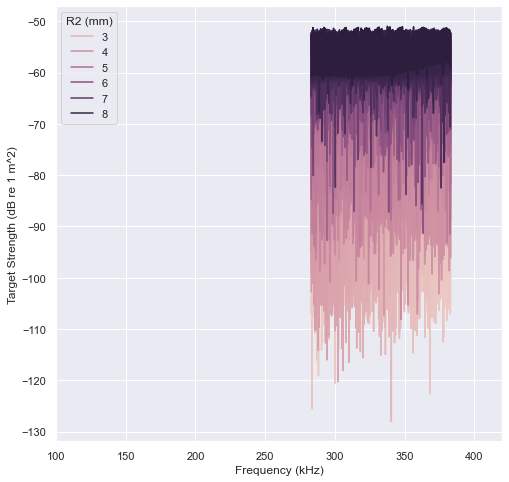

In [16]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_cod',hue='R2 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([100, 420])

(185.0, 383.0)

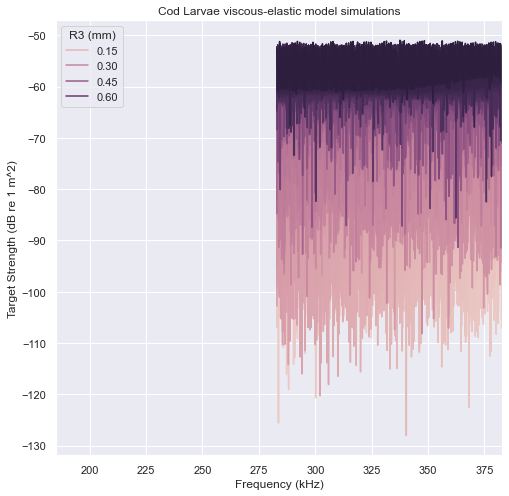

In [17]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_cod',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.title('Cod Larvae viscous-elastic model simulations')
plt.xlim([185, 383])

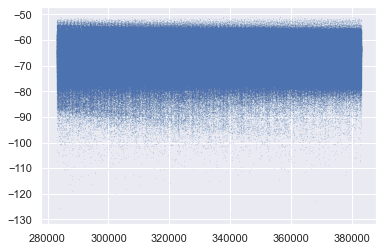

In [18]:
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [19]:
# uncomment when ready.
vefunc.write_ve('./ve_results/ve_simulations_cod_15072022.txt', M_order, params_cod, F_TS_MAT)

In [20]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_cod']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

(283.0, 383.0)

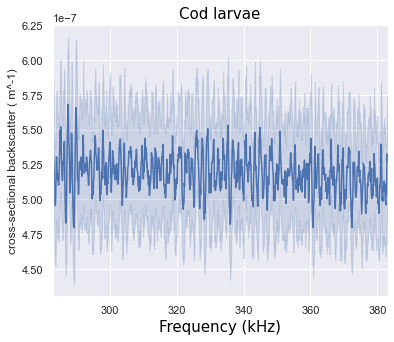

In [21]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='sigbs')
plt.ylabel('cross-sectional backscatter ( m^-1)')
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([283, 383])

(283.0, 383.0)

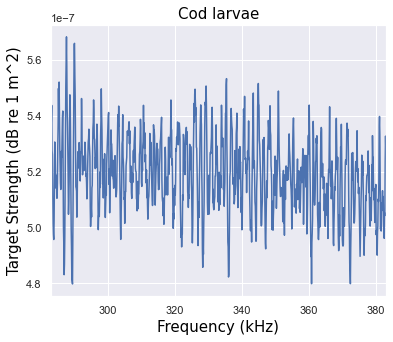

In [22]:
plt.figure(figsize=(6,5))
plt.plot(ve_simdata['freqs'].unique(),mean_bs)
plt.ylabel('Target Strength (dB re 1 m^2)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([283, 383])

In [23]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Cod larvae')

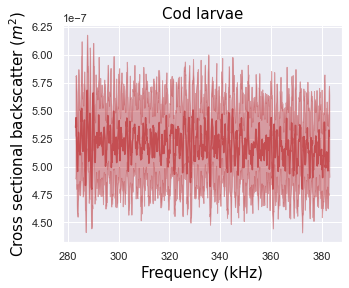

In [24]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Cross sectional backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)

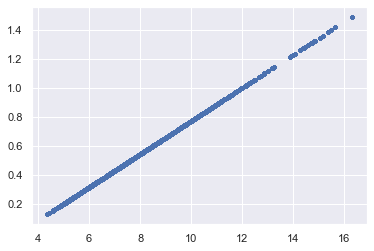

In [25]:
plt.plot(R2_simulations*2,R3_simulations*2, '.')
